This is a starter notebook for the [Kitchenware classification](https://www.kaggle.com/competitions/kitchenware-classification) competition on Kaggle

To get started:

- Join the competition and accept rules
- Download your Kaggle credentials file
- If you're running in Saturn Cloud, configure your instance to have access to access the kaggle credentials

When this is done, we can download the data. We need to execute the following cell only once

In [38]:
!kaggle competitions download -c kitchenware-classification

!unzip kitchenware-classification -d data > /dev/null
!rm kitchenware-classification.zip

 99%|█████████████████████████████████████▋| 1.62G/1.63G [00:22<00:00, 91.0MB/s]
100%|██████████████████████████████████████| 1.63G/1.63G [00:22<00:00, 76.8MB/s]


In [36]:
!echo {"\"username\":"\"hekkoooo\"","\"key"\":"\"07ebdc76d5b704178b01377eb564a8df"\"}" > /home/jovyan/.kaggle/kaggle.json


In [41]:
!cd data && ls

images	sample_submission.csv  test.csv  train.csv


Now let's train a baseline model

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, img_to_array


from tensorflow.keras.applications.xception import preprocess_input


from tensorflow.keras.preprocessing.image import ImageDataGenerator


First, we will load the training dataframe and split it into train and validation

In [8]:
! cd && cd workspace && ls

kitchenware-competition-starter


In [42]:
train = pd.read_csv('data/train.csv')
train['filename'] = 'data/images/' + train['Id'].map(lambda x: f'{x:0>4}.jpg').astype(str)
train.head()

,Id,label,filename
0,560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [43]:
train.shape

(5559, 3)

In [44]:
train["label"].value_counts()

plate    1227
cup      1135
spoon     989
knife     909
glass     742
fork      557
Name: label, dtype: int64

In [45]:
train["label"].value_counts() /5559

plate    0.220723
cup      0.204173
spoon    0.177910
knife    0.163519
glass    0.133477
fork     0.100198
Name: label, dtype: float64

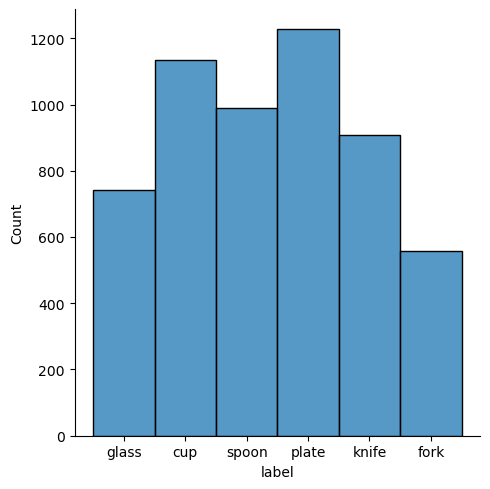

In [46]:
sns.displot(x=train["label"]);

## Data Split

In [47]:
cutoff = int(len(train) * 0.8)
df_train = train[:cutoff]
df_val = train[cutoff:]
print(f'shape of training data is {df_train.shape}, shape of validation data is {df_val.shape}')

shape of training data is (4447, 3), shape of validation data is (1112, 3)


In [48]:
df_train["label"].value_counts()/4447
# the values are approximate to the full dataset

plate    0.221723
cup      0.207556
spoon    0.179447
knife    0.162132
glass    0.131100
fork     0.098044
Name: label, dtype: float64

## Image Exploration

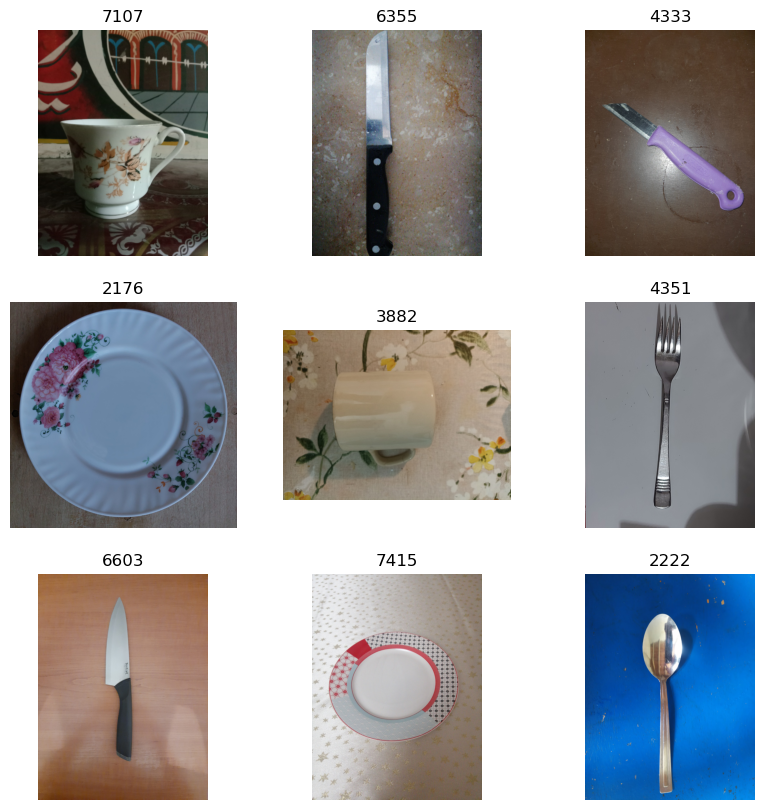

In [50]:
#run cell multiple times for random output
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    i = np.random.randint(0, 3000)
    img = mpimg.imread(train['filename'][i])
    plt.imshow(img)
    plt.title(train['Id'][i])
    plt.axis('off')

## Training Different Models
Since Saturn Cloud is so fast, I will explore different learning rates while training the different models, essentially doing a part of hyperparameter tuning in advance

In [76]:
def train_model(preprocess_input, df_train, df_val, model, epochs=3):
    train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_generator = train_data_generator.flow_from_dataframe(
        df_train,
        x_col='filename',
        y_col='label',
        target_size=(299, 299),
        batch_size=32)

    
    validation_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    validation_generator = validation_data_generator.flow_from_dataframe(
        df_val,
        x_col='filename',
        y_col='label',
        target_size=(299, 299),
        batch_size=32)

    base_model = model
    base_model.trainable = False
    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    scores = {}
    learning_rates = [0.1, 0.01, 0.001]
    for learning_rate in learning_rates:
        print(f"Fitting Model with a learning rate of {learning_rate}.")
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        loss = keras.losses.CategoricalCrossentropy(from_logits=True)
        model.compile(optimizer = optimizer,
                      loss = loss, 
                      metrics=['accuracy'])
        history = model.fit(train_generator,
                            epochs = epochs, 
                            validation_data = validation_generator)
        scores[learning_rate] = history.history
    return model, scores

### Xception

In [59]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_xcep
from tensorflow.keras.applications.xception import decode_predictions

xception_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)
xception_model, xception_scores = train_model(preprocess_input_xcep, df_train, df_val, xception_model)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.
Epoch 1/3
139/139 [==============================] - 76s 532ms/step - loss: 1.5058 - accuracy: 0.8997 - val_loss: 0.9663 - val_accuracy: 0.9379
Epoch 2/3
139/139 [==============================] - 72s 520ms/step - loss: 0.9558 - accuracy: 0.9440 - val_loss: 1.7219 - val_accuracy: 0.9290
Epoch 3/3
139/139 [==============================] - 71s 508ms/step - loss: 0.7138 - accuracy: 0.9577 - val_loss: 1.2915 - val_accuracy: 0.9397
Epoch 1/3
139/139 [==============================] - 76s 533ms/step - loss: 0.3285 - accuracy: 0.9784 - val_loss: 1.0596 - val_accuracy: 0.9523
Epoch 2/3
139/139 [==============================] - 73s 521ms/step - loss: 0.1994 - accuracy: 0.9854 - val_loss: 0.9689 - val_accuracy: 0.9505
Epoch 3/3
139/139 [==============================] - 72s 514ms/step - loss: 0.1370 - accuracy: 0.9872 - val_loss: 0.9492 - val_accuracy: 0.9442
Epoch 1/3
139/

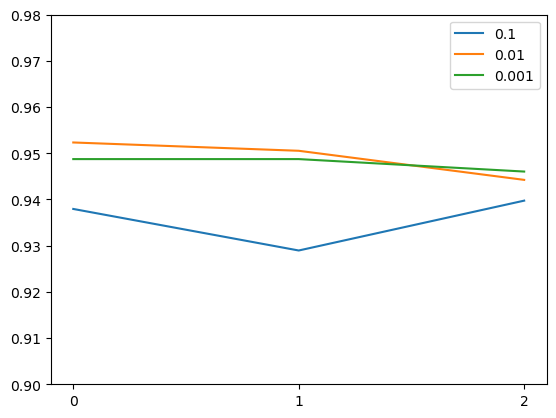

In [65]:
for learning_rate , history_data in xception_scores.items():
    plt.plot(history_data['val_accuracy'], label=learning_rate)
    plt.xticks(np.arange(3))
    plt.ylim(0.9,0.98)
    plt.legend()

at 3 epochs, 0.001 seems to be doing best, however it is likely that 0.1 would do better with longer training. If we decide to use Xception, we will try training it for longer.

### DenseNet

In [66]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_dense

densenet_model= DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

densenet_model, densenet_scores = train_model(preprocess_input_dense, df_train, df_val, densenet_model)

29084464/29084464 [==============================] - 1s 0us/step
Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.
Fitting Model with a learning rate of 0.1.
Epoch 1/3
139/139 [==============================] - 91s 598ms/step - loss: 2.7506 - accuracy: 0.8473 - val_loss: 0.8878 - val_accuracy: 0.9362
Epoch 2/3
139/139 [==============================] - 76s 547ms/step - loss: 0.6548 - accuracy: 0.9436 - val_loss: 1.1831 - val_accuracy: 0.8984
Epoch 3/3
139/139 [==============================] - 76s 544ms/step - loss: 1.1547 - accuracy: 0.9202 - val_loss: 1.1423 - val_accuracy: 0.9406
Fitting Model with a learning rate of 0.01.
Epoch 1/3
139/139 [==============================] - 82s 555ms/step - loss: 0.3782 - accuracy: 0.9699 - val_loss: 0.8686 - val_accuracy: 0.9532
Epoch 2/3
139/139 [==============================] - 75s 540ms/step - loss: 0.2491 - accuracy: 0.9775 - val_loss: 0.8332 - val_accuracy: 0.9496
Epoch 

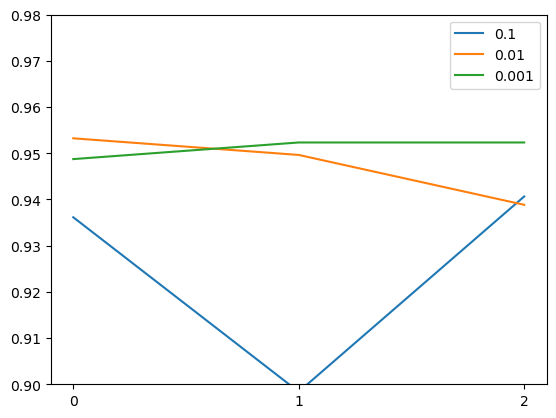

In [81]:
for learning_rate , history_data in densenet_scores.items():
    plt.plot(history_data['val_accuracy'], label=learning_rate)
    plt.xticks(np.arange(3))
    plt.ylim(0.9,0.98)
    plt.legend()

### EfficientNet

In [68]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficient

efficientnet_model = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

efficientnet_model, efficientnet_scores = train_model(preprocess_input_efficient, df_train, df_val, efficientnet_model)

71686520/71686520 [==============================] - 1s 0us/step
Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.
Fitting Model with a learning rate of 0.1.
Epoch 1/3
139/139 [==============================] - 91s 582ms/step - loss: 1.2050 - accuracy: 0.9341 - val_loss: 1.0831 - val_accuracy: 0.9550
Epoch 2/3
139/139 [==============================] - 71s 506ms/step - loss: 0.7641 - accuracy: 0.9620 - val_loss: 1.0719 - val_accuracy: 0.9514
Epoch 3/3
139/139 [==============================] - 70s 506ms/step - loss: 0.5578 - accuracy: 0.9730 - val_loss: 1.2501 - val_accuracy: 0.9505
Fitting Model with a learning rate of 0.01.
Epoch 1/3
139/139 [==============================] - 83s 532ms/step - loss: 0.1794 - accuracy: 0.9892 - val_loss: 0.9897 - val_accuracy: 0.9568
Epoch 2/3
139/139 [==============================] - 71s 508ms/step - loss: 0.0939 - accuracy: 0.9926 - val_loss: 1.0953 - val_accuracy: 0.9532
Epoch 

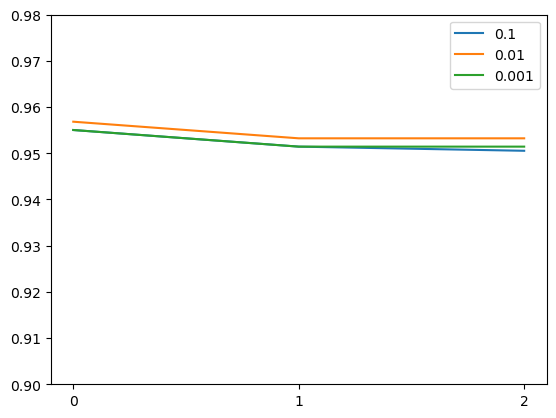

In [73]:
for learning_rate , history_data in efficientnet_scores.items():
    plt.plot(history_data['val_accuracy'], label=learning_rate)
    plt.xticks(np.arange(3))
    plt.ylim(0.9,0.98)
    plt.legend()

### InceptionV3

In [74]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_incV3
inception_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)
inception_model, inception_scores = train_model(preprocess_input_incV3, df_train, df_val, inception_model)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.
Fitting Model with a learning rate of 0.1.
Epoch 1/3
139/139 [==============================] - 81s 547ms/step - loss: 3.5721 - accuracy: 0.8633 - val_loss: 1.4401 - val_accuracy: 0.9335
Epoch 2/3
139/139 [==============================] - 73s 528ms/step - loss: 2.0631 - accuracy: 0.9202 - val_loss: 1.9027 - val_accuracy: 0.9272
Epoch 3/3
139/139 [==============================] - 69s 496ms/step - loss: 1.6907 - accuracy: 0.9330 - val_loss: 2.2487 - val_accuracy: 0.9299
Fitting Model with a learning rate of 0.01.
Epoch 1/3
139/139 [==============================] - 77s 525ms/step - loss: 0.5497 - accuracy: 0.9687 - val_loss: 1.0856 - val_accuracy: 0.9514
Epoch 2/3
139/139 [==============================] - 72s 521ms/step - loss: 0.3592 - accuracy: 0.9750 - val_loss: 1.3723 - val_accuracy: 0.9451
Epoch 3/3
139/139 [==============================] - 69s 496ms/step - l

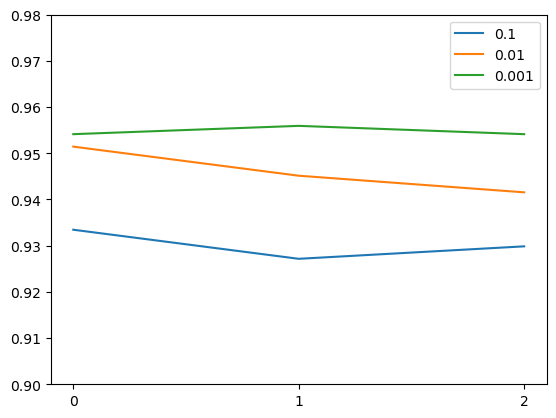

In [75]:
for learning_rate , history_data in inception_scores.items():
    plt.plot(history_data['val_accuracy'], label=learning_rate)
    plt.xticks(np.arange(3))
    plt.ylim(0.9,0.98)
    plt.legend()

## Hyperparameter Tuning

In [87]:
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_data_generator.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32)


validation_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_data_generator.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(299, 299),
    batch_size=32)

for dropout_rate in [0.3,0.5, 0.8]:
    for dense_layer_size in [100,300]:
        print(f"Hyperparameter tuning with drop out rate of {dropout_rate} and dense layer size of {dense_layer_size}")
        base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )
        base_model.trainable = False
        inputs = keras.Input(shape=(299,299,3))
        base = base_model(inputs, training=False)
        vectors = keras.layers.GlobalAveragePooling2D()(base)
        inner = keras.layers.Dense(dense_layer_size, activation='relu')(vectors)
        dropout = keras.layers.Dropout(dropout_rate)(inner)
        outputs = keras.layers.Dense(6)(dropout)
        model = keras.Model(inputs, outputs)
        optimizer = keras.optimizers.Adam(learning_rate=0.1)
        loss = keras.losses.CategoricalCrossentropy(from_logits=True)

        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=['accuracy']
        )
        checkpoint = keras.callbacks.ModelCheckpoint(
            'xception{epoch:02d}_{val_accuracy:.3f}.h5',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )

        history = model.fit(train_generator, epochs=4, validation_data=validation_generator, callbacks=[checkpoint])

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.
Hyperparameter tuning with drop out rate of 0.3 and dense layer size of 100
Epoch 1/4
139/139 [==============================] - 77s 533ms/step - loss: 2.1240 - accuracy: 0.7659 - val_loss: 0.3163 - val_accuracy: 0.9317
Epoch 2/4
139/139 [==============================] - 72s 519ms/step - loss: 0.7807 - accuracy: 0.7808 - val_loss: 1.0907 - val_accuracy: 0.6879
Epoch 3/4
139/139 [==============================] - 73s 522ms/step - loss: 1.1419 - accuracy: 0.6072 - val_loss: 0.9284 - val_accuracy: 0.6430
Epoch 4/4
139/139 [==============================] - 68s 492ms/step - loss: 1.2827 - accuracy: 0.5336 - val_loss: 0.9177 - val_accuracy: 0.6457
Hyperparameter tuning with drop out rate of 0.3 and dense layer size of 300
Epoch 1/4
139/139 [==============================] - 72s 500ms/step - loss: 5.2975 - accuracy: 0.8026 - val_loss: 0.3521 - val_accuracy: 0.9002
Epoch 

While validation accuracy is much lower, some epocs have higher validation accuracy than train accuracy, meaning it is not overfitting. 
Lets see how it performs with only hyperparameter tuning of learning rate (and a higher number of epocs)

In [89]:
xception_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)
xception_model2, xception_scores2 = train_model(preprocess_input_xcep, df_train, df_val, xception_model, epochs=10)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.
Fitting Model with a learning rate of 0.1.
Epoch 1/10
139/139 [==============================] - 75s 524ms/step - loss: 1.3170 - accuracy: 0.9022 - val_loss: 0.7401 - val_accuracy: 0.9478
Epoch 2/10
139/139 [==============================] - 70s 507ms/step - loss: 0.8449 - accuracy: 0.9492 - val_loss: 1.0324 - val_accuracy: 0.9415
Epoch 3/10
139/139 [==============================] - 71s 507ms/step - loss: 0.7886 - accuracy: 0.9550 - val_loss: 1.1565 - val_accuracy: 0.9353
Epoch 4/10
139/139 [==============================] - 69s 495ms/step - loss: 0.6741 - accuracy: 0.9597 - val_loss: 1.3882 - val_accuracy: 0.9317
Epoch 5/10
139/139 [==============================] - 70s 501ms/step - loss: 0.4325 - accuracy: 0.9726 - val_loss: 1.4826 - val_accuracy: 0.9379
Epoch 6/10
139/139 [==============================] - 68s 491ms/step - loss: 0.4427 - accuracy: 0.9726 - val_l

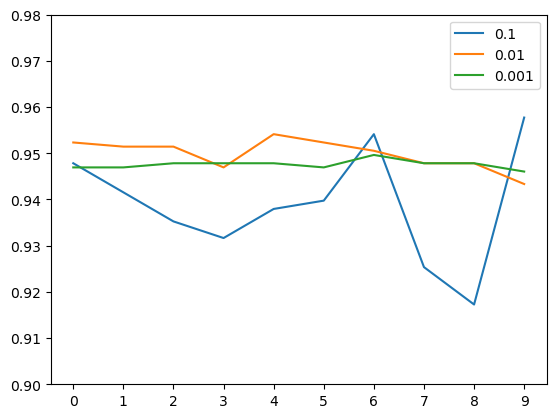

In [90]:
for learning_rate , history_data in xception_scores2.items():
    plt.plot(history_data['val_accuracy'], label=learning_rate)
    plt.xticks(np.arange(10))
    plt.ylim(0.9,0.98)
    plt.legend()

lets experiment with the outcome

In [223]:
df_test = pd.read_csv('data/test.csv')
df_test['filename'] = 'data/images/' + df_test['Id'].map(lambda x: f'{x:0>4}.jpg').astype(str)
df_test.head()

,Id,filename
0,678,data/images/0678.jpg
1,3962,data/images/3962.jpg
2,9271,data/images/9271.jpg
3,5133,data/images/5133.jpg
4,8842,data/images/8842.jpg


In [224]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xcep)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 3808 validated image filenames.


In [226]:
y_pred = xception_model2.predict(test_generator)
classes = np.array(list(train_generator.class_indices.keys()))
predictions = classes[y_pred.argmax(axis=1)]
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions
df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]

119/119 [==============================] - 59s 498ms/step


In [227]:
df_submission.shape

(3808, 3)

In [161]:
def predict(model, image_path):
    model = model
    img = load_img(image_path)
    img = img.resize((299, 299))
    arr = np.array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input_xcep(arr)
    y_pred = model.predict(arr)
    return classes[y_pred.argmax(axis=1)]

def plot_it(model, image_path):
    prediction=predict(model, image_path)
    plt.figure(figsize=(10, 10))
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(prediction)
    plt.axis('off')

1/1 [==============================] - 0s 21ms/step


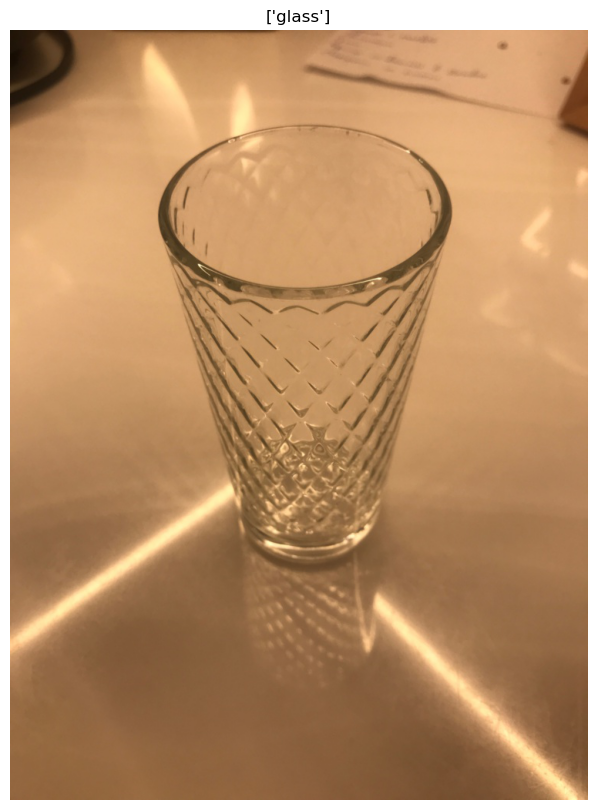

In [234]:
# but still confusing glass cups at times 
plot_it(xception_model2,'data/images/0560.jpg')

1/1 [==============================] - 0s 22ms/step


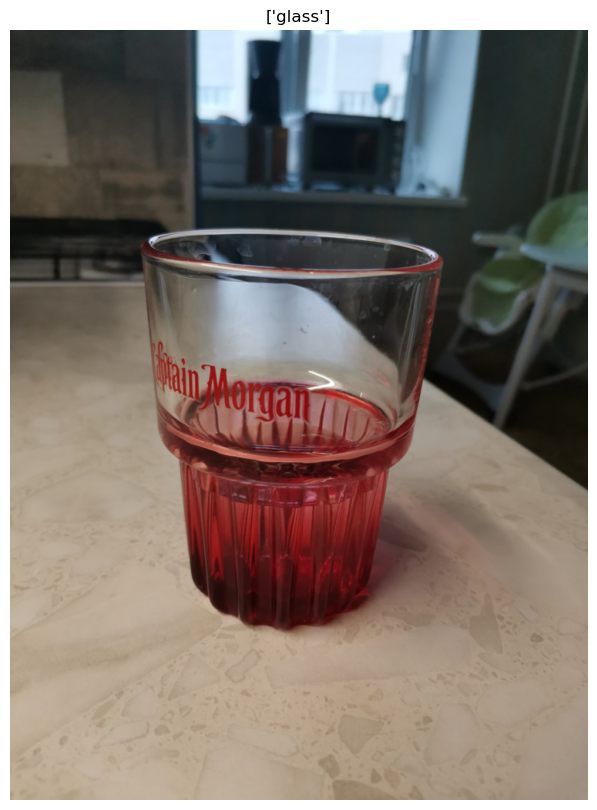

In [236]:
#Xception 2 - try out with different ids from df_submission to confirm correct results - it seems to be getting most right
# but still confusing glass cups at times 
plot_it(xception_model2, (df_submission.sample()['filename']).values[0])

In [230]:
df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [231]:
!kaggle competitions submit kitchenware-classification -f submission.csv -m 'validation accuracy: 0.952'

100%|██████████████████████████████████████| 38.9k/38.9k [00:00<00:00, 52.2kB/s]
Successfully submitted to Kitchenware Classification

that got a public score of **0.94263**. Now lets save this one and try one of the lower scored hyperparameter tuned models

In [237]:
xception_model2.save('xception_only_lr.h5')

In [238]:
 xception_tuned = keras.models.load_model('xception04_0.924.h5')

In [241]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xcep)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 3808 validated image filenames.


In [242]:
y_pred = xception_tuned.predict(test_generator)
classes = np.array(list(train_generator.class_indices.keys()))
predictions = classes[y_pred.argmax(axis=1)]
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions
df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]
df_submission

119/119 [==============================] - 56s 473ms/step


,filename,label,Id
0,data/images/0678.jpg,fork,0678
1,data/images/3962.jpg,knife,3962
2,data/images/9271.jpg,fork,9271
3,data/images/5133.jpg,plate,5133
4,data/images/8842.jpg,fork,8842
...,...,...,...
3803,data/images/7626.jpg,plate,7626
3804,data/images/2052.jpg,cup,2052
3805,data/images/8827.jpg,spoon,8827
3806,data/images/2299.jpg,fork,2299


1/1 [==============================] - 1s 665ms/step


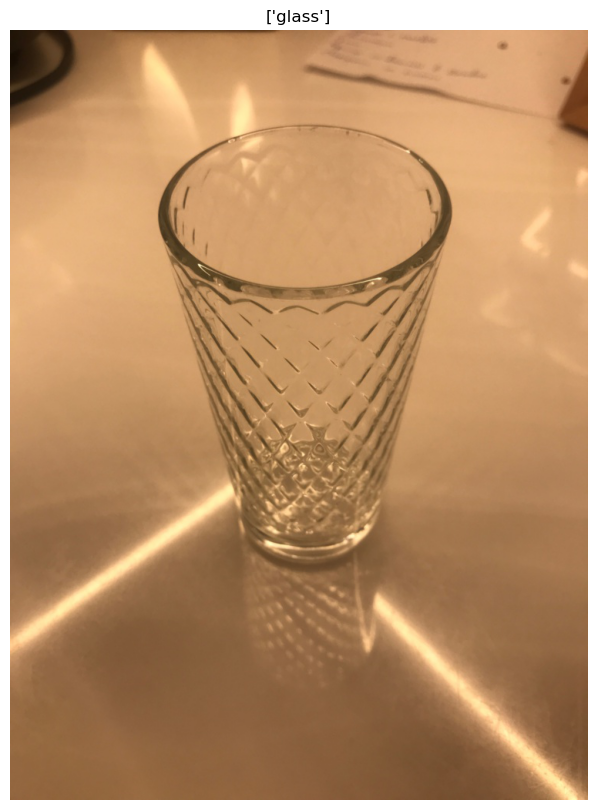

In [243]:
plot_it(xception_tuned,'data/images/0560.jpg')

1/1 [==============================] - 0s 22ms/step


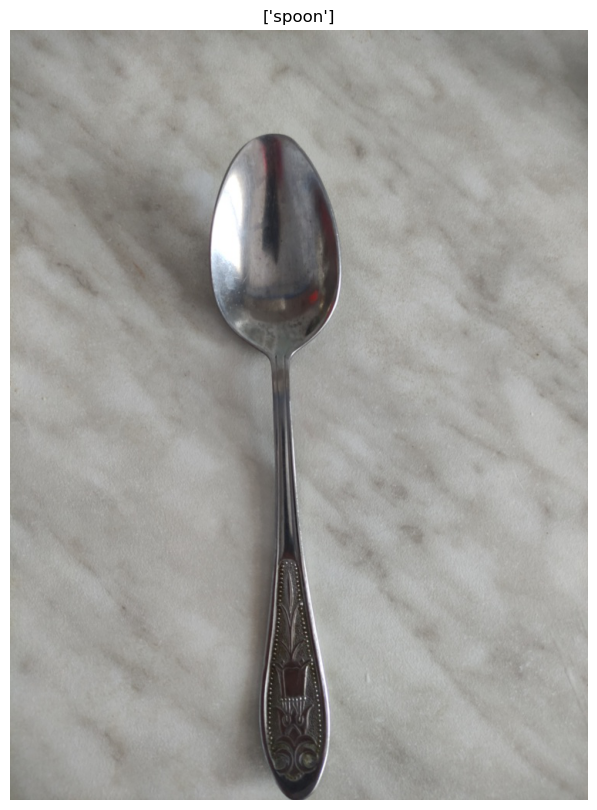

In [245]:
plot_it(xception_tuned, (df_submission.sample()['filename']).values[0])

In [246]:
df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [247]:
!kaggle competitions submit kitchenware-classification -f submission.csv -m 'validation: 0.92'

100%|██████████████████████████████████████| 39.2k/39.2k [00:00<00:00, 57.7kB/s]
Successfully submitted to Kitchenware Classification

that got **0.9049** so the model with a 0.001 Learning Rate and no other architectural adjustments was better. I do believe that a model with 0.01 learning rate might perform better, but this will do, for now.

In [249]:
!pip install bentoml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.0/218.0 kB 36.4 MB/s e

In [251]:
import bentoml

In [252]:
bentoml.keras.save_model("kitchware-classification", xception_model2)

INFO:tensorflow:Assets written to: /tmp/tmp4bprdj6hbentoml_model_kitchware-classification/assets


INFO:tensorflow:Assets written to: /tmp/tmp4bprdj6hbentoml_model_kitchware-classification/assets


Model(tag="kitchware-classification:tam57aeaskqssrxd", path="/home/jovyan/bentoml/models/kitchware-classification/tam57aeaskqssrxd/")